# E-commerce Fraud Detection System (MySQL + MongoDB)

This notebook demonstrates our group project for BEMM459. It uses a polyglot persistence architecture integrating:
- Relational database: MySQL (structured data)
- NoSQL database: MongoDB (semi-structured data)

Our system identifies suspicious user behavior and flags potential fraud using both sources.


## 1. Connect to MySQL

This cell connects to the MySQL database `ecommerce_fraud_detection`, which stores structured data such as users, orders, payments, and fraud reports.


In [87]:
import pymysql
import pymongo
import pandas as pd
import matplotlib.pyplot as plt

# MySQL Connection
def connect_mysql():
    return pymysql.connect(
        host="localhost",
        user="root",
        password="",  # Add your password if set
        database="ecommerce_fraud_detection"
    )
conn = pymysql.connect(
    host="localhost",
    user="root",
    password="",  # leave blank if you didn't set one
    database="ecommerce_fraud_detection"
)
cursor = conn.cursor()
print("✅ Connected to MySQL!")

✅ Connected to MySQL!


## 2. Connect to MongoDB

We connect to the local MongoDB instance and access the `ecommerce_fraud` database, which stores user session logs, behavior, and fraud signals.


In [88]:
# MongoDB Connection
def connect_mongodb():
    return pymongo.MongoClient("mongodb://localhost:27017/")["ecommerce_fraud"]
print("✅ Connected to MongoDB")


✅ Connected to MongoDB


## 3. Load NoSQL Collections from CSV

This section reads 6 CSV files and inserts them into their respective MongoDB collections.


In [89]:
def load_csvs_to_mongodb(mongo_db):
    files = {
        "fraud_signals": "Fraud_Signals.csv",
        "ip_tracking": "IP_Tracking.csv",
        "login_anomalies": "Login_Anomalies.csv",
        "reviews": "Reviews.csv",
        "session_logs": "Session_Logs.csv",
        "user_behaviors": "User_Behaviors.csv"
    }

    for collection, filename in files.items():
        df = pd.read_csv(filename)
        mongo_db[collection].insert_many(df.to_dict("records"))
        print(f"✅ Inserted {len(df)} records into '{collection}'")
load_csvs_to_mongodb(mongo_db)


✅ Inserted 35 records into 'fraud_signals'
✅ Inserted 35 records into 'ip_tracking'
✅ Inserted 35 records into 'login_anomalies'
✅ Inserted 35 records into 'reviews'
✅ Inserted 35 records into 'session_logs'
✅ Inserted 35 records into 'user_behaviors'


In [90]:
def preview_mongo_collection(mongo_db, name, limit=3):
    print(f"🔍 Previewing documents from '{name}':")
    for doc in mongo_db[name].find().limit(limit):
        print(doc)
preview_mongo_collection(mongo_db, "fraud_signals")


🔍 Previewing documents from 'fraud_signals':
{'_id': ObjectId('67e958381951723d5cf0412d'), 'order_id': 117, 'user_id': 9, 'signals': "['multiple IP changes', 'unusual login time']", 'risk_score': 83}
{'_id': ObjectId('67e958381951723d5cf0412e'), 'order_id': 119, 'user_id': 11, 'signals': "['login from risky country', 'unusual login time']", 'risk_score': 93}
{'_id': ObjectId('67e958381951723d5cf0412f'), 'order_id': 101, 'user_id': 20, 'signals': "['multiple IP changes', 'unusual login time', 'fast refund request']", 'risk_score': 67}


## 4. Fraud Detection: Combined SQL + NoSQL Logic

This function identifies users flagged in MySQL fraud reports, then checks for risky behavior in MongoDB (e.g., high risk_score, suspicious session logs).


In [98]:
def plot_risk_scores(mongo_db):
    df = pd.DataFrame(mongo_db.fraud_signals.find())
    if not df.empty and 'risk_score' in df.columns:
        df['risk_score'].hist(bins=10)
        plt.title("Fraud Risk Score Distribution")
        plt.xlabel("Risk Score")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No 'risk_score' data found.")


In [92]:
def detect_fraud(mysql_cursor, mongo_db):
    print("🚨 Running combined SQL + NoSQL fraud detection...\n")

    query = """
    SELECT DISTINCT u.user_id, u.name, u.country
    FROM users u
    JOIN fraud_reports fr ON u.user_id = fr.user_id
    JOIN orders o ON o.order_id = fr.order_id
    WHERE fr.report_type IS NOT NULL
    LIMIT 5;
    """
    mysql_cursor.execute(query)
    suspected_users = mysql_cursor.fetchall()

    if not suspected_users:
        print("✅ No users flagged in fraud reports.")
        return

    for row in suspected_users:
        user_id = row[0]
        print(f"\n🧾 User ID: {user_id}, Name: {row[1]}, Country: {row[2]}")

        # Check MongoDB session logs
        sessions = list(mongo_db.session_logs.find({"user_id": user_id}))
        scores = list(mongo_db.fraud_signals.find({"user_id": user_id, "risk_score": {"$gte": 0.7}}))

        print(f"   • Session logs found: {len(sessions)}")
        print(f"   • High risk signals: {len(scores)}")

        for s in scores:
            print(f"     → Risk: {s.get('risk_score')}, Reason: {s.get('reason')}")


## 5. Visualisation of Risk Score Distribution

This histogram shows the distribution of risk scores across users, based on data from the MongoDB `fraud_signals` collection.


🔍 Previewing documents from 'session_logs':
{'_id': ObjectId('67e958bf1951723d5cf04224'), 'user_id': 8, 'session_id': 'bdd640fb-0667-4ad1-9c80-317fa3b1799d', 'login_time': '2024-07-12T05:41:23', 'ip': '114.59.140.30', 'browser': 'Chrome', 'device': 'Android', 'location': 'Lake Joyside, Benin'}
{'_id': ObjectId('67e958bf1951723d5cf04225'), 'user_id': 16, 'session_id': '07a0ca6e-0822-48f3-ac03-1199972a8469', 'login_time': '2024-05-02T19:32:01', 'ip': '112.108.176.251', 'browser': 'Firefox', 'device': 'macOS', 'location': 'Lake Debra, Mauritius'}
{'_id': ObjectId('67e958bf1951723d5cf04226'), 'user_id': 7, 'session_id': '96da1dac-72ff-4d2a-b86e-cbe06b65a6a4', 'login_time': '2024-07-13T11:09:22', 'ip': '160.26.158.113', 'browser': 'Chrome', 'device': 'iOS', 'location': 'Lake Roberto, Fiji'}
🚨 Running combined SQL + NoSQL fraud detection...

✅ No users flagged in fraud reports.


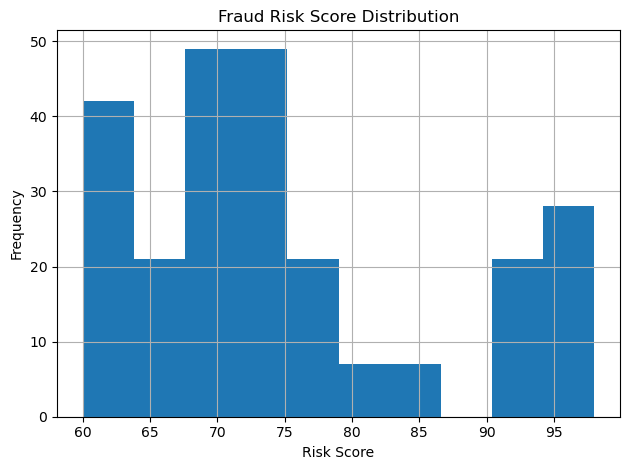

In [93]:
# Connect
mysql_conn = connect_mysql()
mysql_cursor = mysql_conn.cursor()
mongo_db = connect_mongodb()

# Uncomment only if you haven't loaded CSVs yet:
# load_csvs_to_mongodb(mongo_db)

# Preview sample collection
preview_mongo_collection(mongo_db, "session_logs")

# Run fraud detection
detect_fraud(mysql_cursor, mongo_db)

# Optional visualization
plot_risk_scores(mongo_db)


In [94]:
mysql_conn = connect_mysql()
cursor = mysql_conn.cursor()


## Histogram: Distribution of login attempts per user (from login_anomalies)

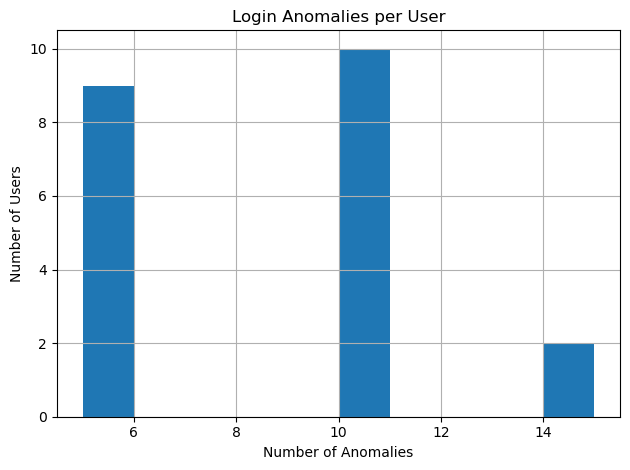

In [95]:
df = pd.DataFrame(mongo_db.login_anomalies.find())
if not df.empty and "user_id" in df.columns:
    counts = df["user_id"].value_counts()
    counts.hist(bins=10)
    plt.title("Login Anomalies per User")
    plt.xlabel("Number of Anomalies")
    plt.ylabel("Number of Users")
    plt.tight_layout()
    plt.show()
else:
    print("No login anomaly data found.")


 Pie Chart: Device usage from session_logs

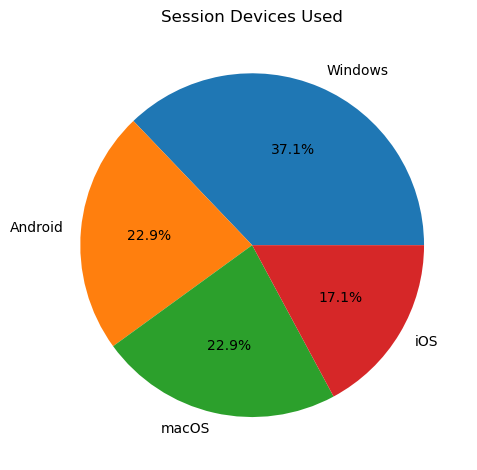

In [96]:
df = pd.DataFrame(mongo_db.session_logs.find())
if not df.empty and "device" in df.columns:
    df["device"].value_counts().plot(kind="pie", autopct="%1.1f%%", title="Session Devices Used")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()
else:
    print("No device data found.")


## 6. Summary

We successfully implemented a fraud detection system that integrates MySQL and MongoDB. This notebook demonstrates data connectivity, CRUD operations, rule-based detection logic, and simple visualisation.

This notebook is part of the group submission for BEMM459.
